<div style="text-align: center;">

# From scattered data to gridded products

## [Tutorial at Transform 2020](https://sched.co/c7KE) 💚

<img src="https://github.com/fatiando/verde/raw/c77c7d84aa361fb1209ae38f7d6a05253a4518fc/doc/_static/readme-banner.png" style="width: 70%">

### A hands-on tour of Verde, a Python package for processing and gridding geophysical/geospatial data with a twist of machine learning.
    
</div>

<br>

**Instructors:**
[Leonardo Uieda](https://www.leouieda.com/)<sup>1</sup> and
[Santiago Soler](https://santisoler.github.io/)<sup>2,3</sup>

<sup>1</sup>University of Liverpool, UK |
<sup>2</sup>CONICET, Argentina | 
<sup>3</sup>Universidad Nacional de San Juan, Argentina

## Useful links

* Live stream: https://youtu.be/-xZdNdvzm3E
* Workshop material: https://github.com/fatiando/transform2020 
* Verde documentation | https://www.fatiando.org/verde

## Contents

1. [Loading data](#load)
1. [Projections](#projections)
1. [Trends](#trends)
1. [Blocked reductions](#reduction)
1. [Gridding with splines](#gridding)
1. [Chainning operations](#chain)
1. [Training and validation split](#train-test-split)
1. [Cross-validation](#cv)
1. [Hyper-parameter optimization](#splinecv)

## Importing libraries

The first thing we'll do is import all of the libraries that we need:

In [1]:
import verde as vd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
import pyproj
import pooch

In [2]:
# Make matplotlib figures larger
plt.rcParams["figure.dpi"] = 120

<a id="load"></a>

## Loading data

In [3]:
fname = pooch.retrieve(
    "https://raw.githubusercontent.com/fatiando/transform2020/master/data/ew9105.m77t", 
    known_hash="md5:27a0f501251b9dd5a1413722e1c406ea",
)

In [4]:
data = pd.read_csv(fname, sep="\t")
data

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
0,EW9105,0,19910804,59.5,-27.46909,-79.68620,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EW9105,0,19910804,100.0,-27.46815,-79.68756,3,NaN,5.401,4046.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EW9105,0,19910804,101.0,-27.46627,-79.69027,3,NaN,5.405,4049.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EW9105,0,19910804,102.0,-27.46439,-79.69298,3,NaN,5.401,4046.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EW9105,0,19910804,103.0,-27.46251,-79.69571,3,NaN,5.406,4050.0,...,NaN,NaN,NaN,NaN,NaN,NaN,21.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63535,EW9105,0,19910917,204.0,-21.82675,-108.74021,3,NaN,4.962,3714.0,...,NaN,NaN,NaN,NaN,NaN,NaN,21.6,NaN,NaN,NaN
63536,EW9105,0,19910917,205.0,-21.82975,-108.74036,3,NaN,4.965,3716.0,...,NaN,NaN,NaN,NaN,NaN,NaN,20.8,NaN,NaN,NaN
63537,EW9105,0,19910917,206.0,-21.83275,-108.74051,3,NaN,4.959,3711.0,...,NaN,NaN,NaN,NaN,NaN,NaN,21.6,NaN,NaN,NaN
63538,EW9105,0,19910917,207.0,-21.83576,-108.74066,3,NaN,4.961,3713.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


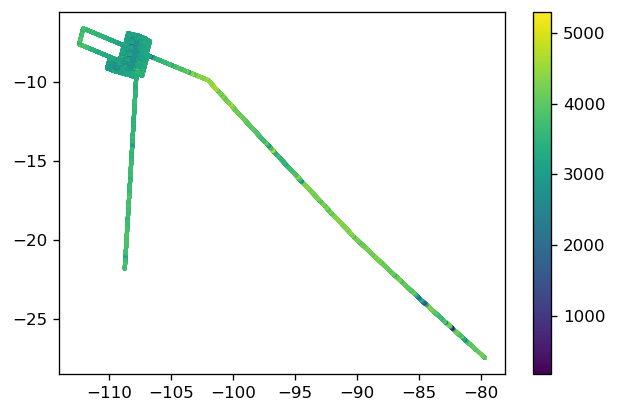

In [5]:
plt.figure()
plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)
plt.colorbar()

In [6]:
data = data[vd.inside((data.LON, data.LAT), [-110, -107, -9.5, -5])]
data = data.dropna(subset=["CORR_DEPTH"])
data

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
10417,EW9105,0,19910811,624.0,-8.28569,-107.00034,3,NaN,4.413,3298.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9.5,NaN,NaN,NaN
10418,EW9105,0,19910811,625.0,-8.28484,-107.00307,3,NaN,4.512,3373.0,...,NaN,NaN,NaN,NaN,NaN,NaN,11.7,NaN,NaN,NaN
10419,EW9105,0,19910811,626.0,-8.28398,-107.00578,3,NaN,4.518,3377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,12.8,NaN,NaN,NaN
10420,EW9105,0,19910811,627.0,-8.28314,-107.00850,3,NaN,4.526,3383.0,...,NaN,NaN,NaN,NaN,NaN,NaN,13.4,NaN,NaN,NaN
10421,EW9105,0,19910811,628.0,-8.28230,-107.01122,3,NaN,4.447,3324.0,...,NaN,NaN,NaN,NaN,NaN,NaN,13.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59456,EW9105,0,19910914,613.0,-9.48615,-107.79604,3,NaN,4.662,3486.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59457,EW9105,0,19910914,614.0,-9.48906,-107.79695,3,NaN,4.678,3499.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59458,EW9105,0,19910914,615.0,-9.49194,-107.79783,3,NaN,4.677,3498.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59459,EW9105,0,19910914,616.0,-9.49483,-107.79870,3,NaN,4.681,3501.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


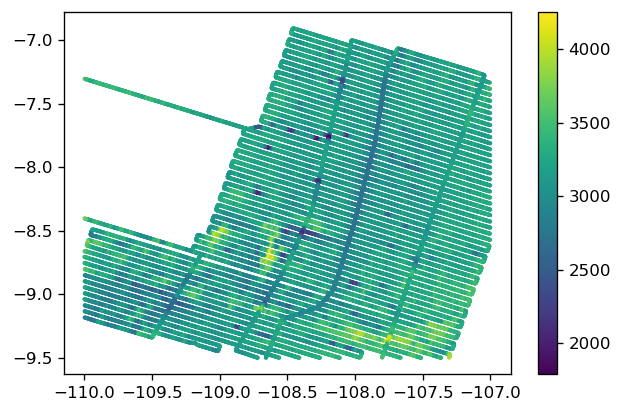

In [7]:
plt.figure()
plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)
plt.colorbar()

<a id="projections"></a>

## Projections

In [8]:
projection = pyproj.Proj(proj="merc", lat_ts=data.LAT.mean())

In [9]:
coordinates = projection(data.LON.values, data.LAT.values)

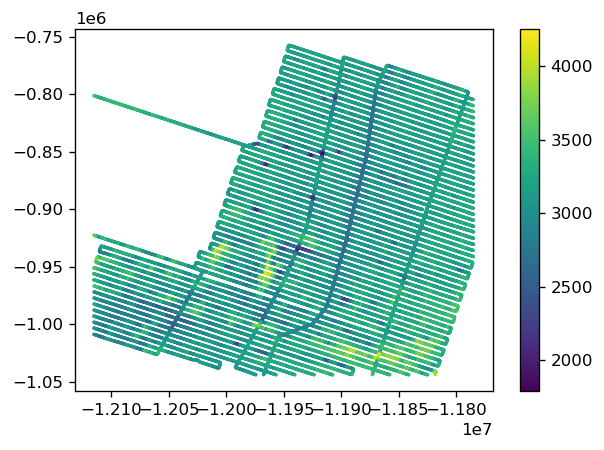

In [10]:
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=data.CORR_DEPTH, s=1)
plt.axis("scaled")
plt.colorbar()

<a id="trends"></a>

## Trends

In [11]:
trend = vd.Trend(degree=3)

In [12]:
trend.fit(coordinates, data.CORR_DEPTH)

Trend(degree=3)

In [13]:
regional = trend.predict(coordinates)

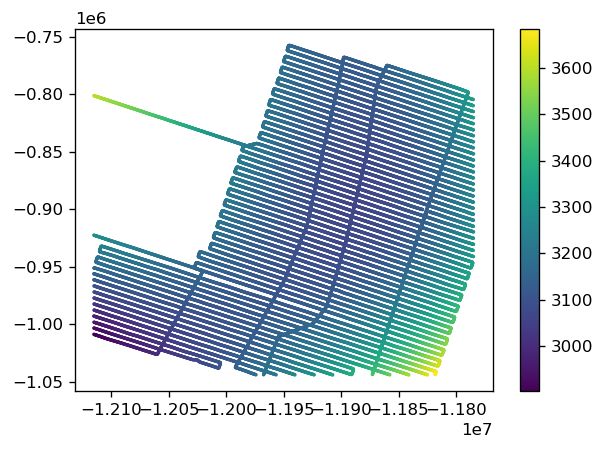

In [14]:
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=regional, s=1)
plt.axis("scaled")
plt.colorbar()

In [15]:
residual = data.CORR_DEPTH - regional

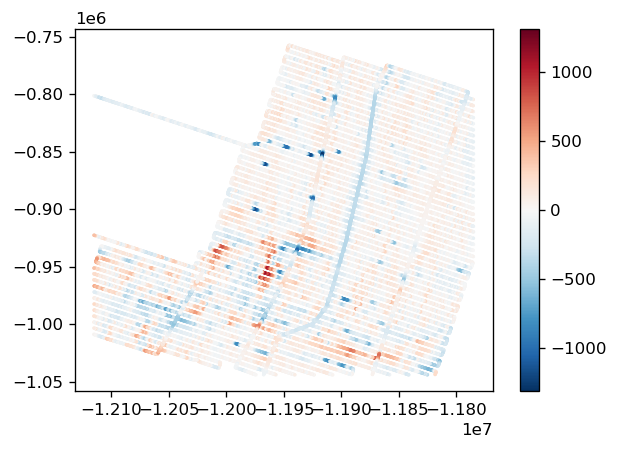

In [16]:
scale = vd.maxabs(residual)
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=residual, s=1, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.axis("scaled")
plt.colorbar()

<a id="reduction"></a>

## Blocked reductions

In [17]:
reducer = vd.BlockReduce(np.median, spacing=5000)

In [18]:
block_coords, block_bathymetry = reducer.filter(coordinates, data.CORR_DEPTH)

In [19]:
data.shape

(44376, 26)

In [20]:
block_bathymetry.shape

(2620,)

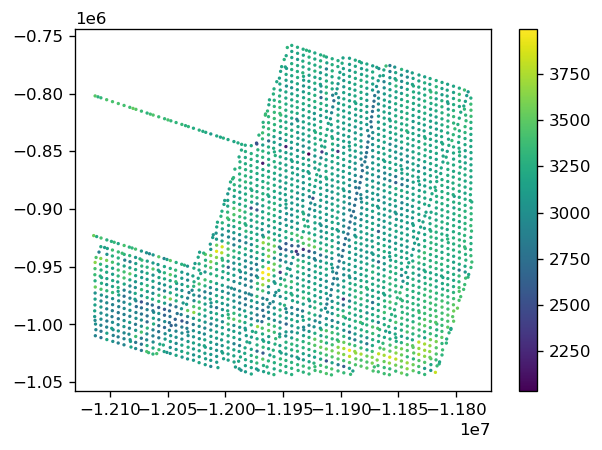

In [21]:
plt.figure()
plt.scatter(block_coords[0], block_coords[1], c=block_bathymetry, s=1)
plt.axis("scaled")
plt.colorbar()

<a id="gridding"></a>

## Gridding with splines

In [22]:
spline = vd.Spline()

In [23]:
spline.fit(block_coords, block_bathymetry)

Spline()

In [24]:
predicted = spline.predict(coordinates)

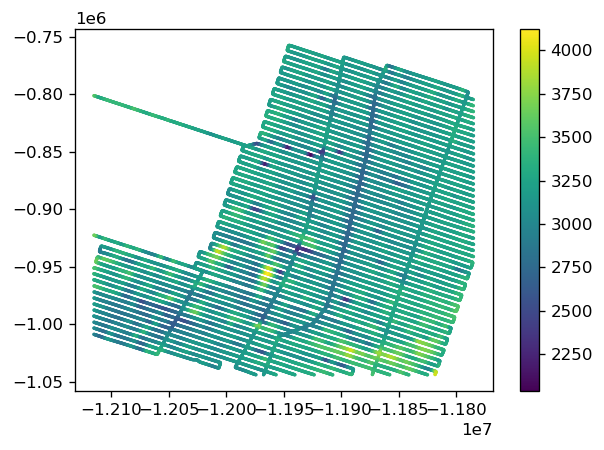

In [25]:
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=predicted, s=1)
plt.axis("scaled")
plt.colorbar()

In [26]:
spline_residual = data.CORR_DEPTH - predicted

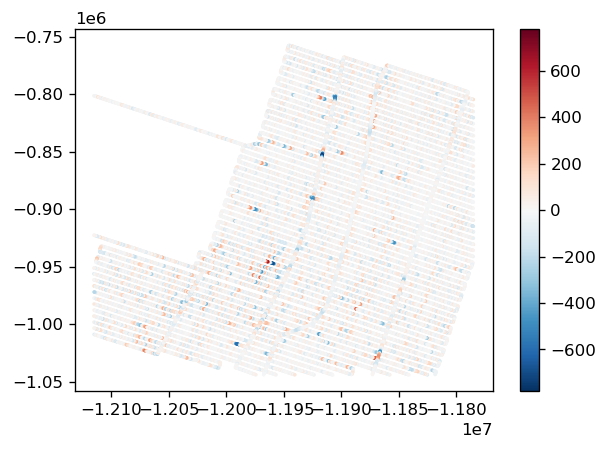

In [27]:
scale = vd.maxabs(spline_residual)

plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=spline_residual, s=1, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.axis("scaled")
plt.colorbar()

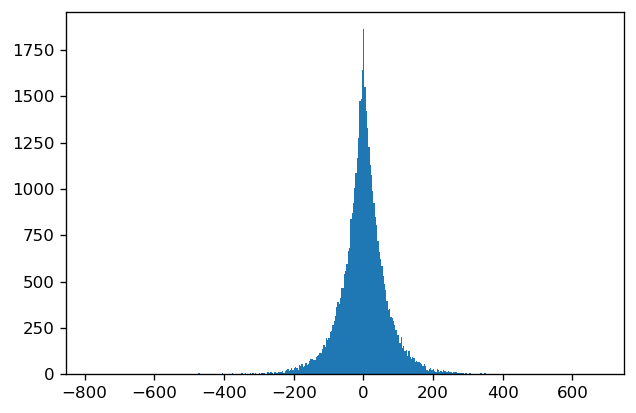

In [28]:
plt.figure()
plt.hist(spline_residual, bins="auto")
plt.show()

<div style="background-color: #a3ff8e; border-radius: 3px; padding: 10px; text-align: center;">

# ☕ Break (20 min)
    
</div>

## Gridding with splines (continued)

In [29]:
grid_coords = vd.grid_coordinates(vd.get_region(coordinates), spacing=2000)

In [30]:
grid_bathymetry = spline.predict(grid_coords)

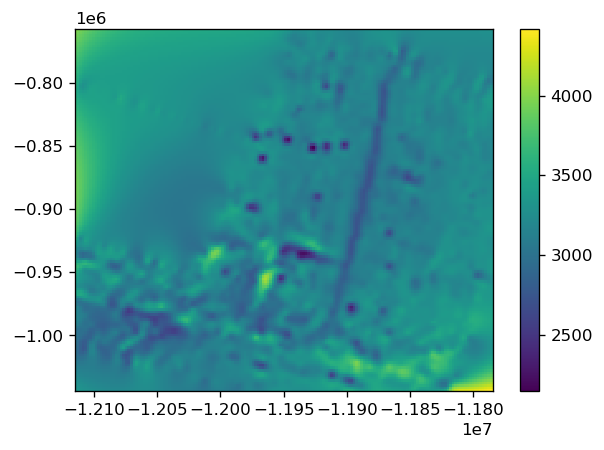

In [31]:
plt.figure()
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_bathymetry)
plt.axis("scaled")
plt.colorbar()

In [32]:
grid = spline.grid(spacing=2000)

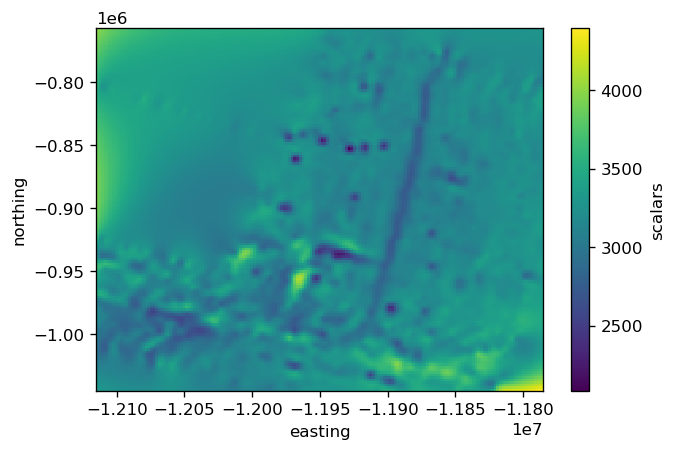

In [33]:
grid.scalars.plot()

In [34]:
grid = vd.distance_mask(coordinates, maxdist=10e3, grid=grid)

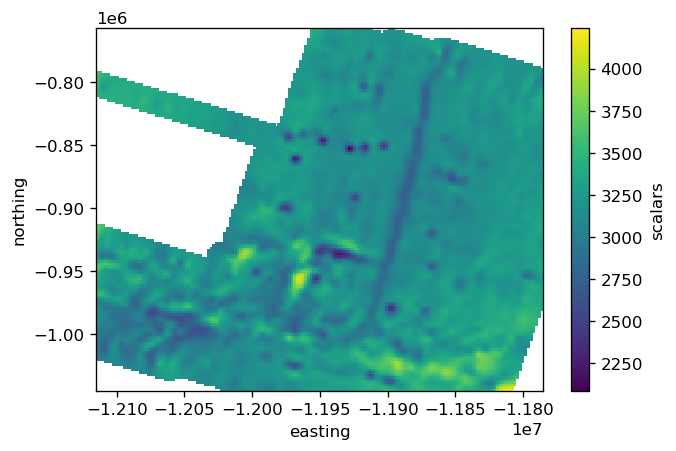

In [35]:
grid.scalars.plot()

<a id="chain"></a>

## Chainning operations

In [40]:
chain = vd.Chain([
    ("trend", vd.Trend(degree=1)),
    ("reduce", vd.BlockReduce(np.median, spacing=5000)),
    ("spline", vd.Spline()),
])
chain

Chain(steps=[('trend', Trend(degree=1)),
             ('reduce',
              BlockReduce(reduction=<function median at 0x7f6c54385d90>,
                          spacing=5000)),
             ('spline', Spline())])

In [41]:
chain.fit(coordinates, data.CORR_DEPTH)

Chain(steps=[('trend', Trend(degree=1)),
             ('reduce',
              BlockReduce(reduction=<function median at 0x7f6c54385d90>,
                          spacing=5000)),
             ('spline', Spline())])

In [42]:
grid = chain.grid(spacing=2000)

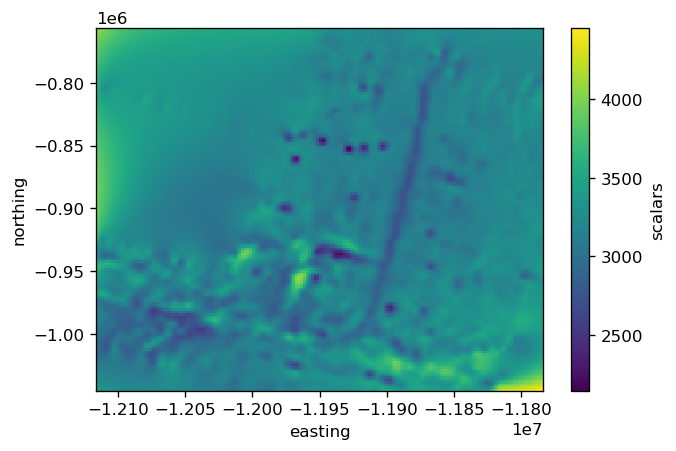

In [43]:
grid.scalars.plot()

<a id="train-test-split"></a>

## Training and validation split

In [68]:
train, test = vd.train_test_split(coordinates, data.CORR_DEPTH, random_state=0, test_size=0.1)

In [64]:
train

((array([-11784785.2164437 , -11785085.89271857, -11785384.36623684, ...,
         -11872619.03418915, -11872714.85410092, -11872802.96436462]),
  array([ -909677.28127517,  -909583.296975  ,  -909488.20718652, ...,
         -1043269.78931534, -1043590.40536917, -1043904.36768959])),
 (array([3298., 3373., 3377., ..., 3498., 3501., 3513.]),),
 (None,))

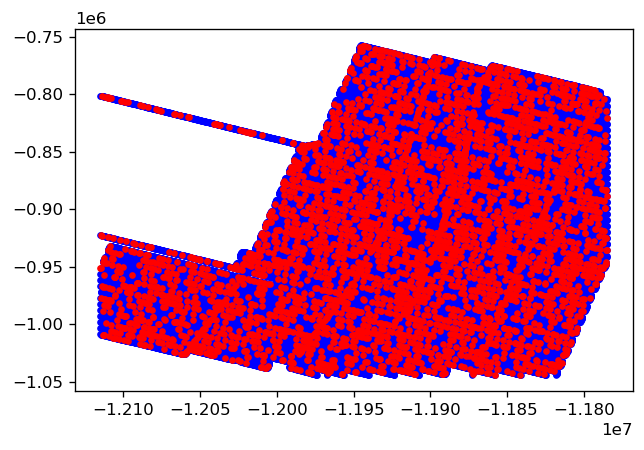

In [72]:
plt.plot(train[0][0], train[0][1], ".b")
plt.plot(test[0][0], test[0][1], ".r")

In [73]:
chain.fit(*train)

Chain(steps=[('trend', Trend(degree=1)),
             ('reduce',
              BlockReduce(reduction=<function median at 0x7f6c54385d90>,
                          spacing=5000)),
             ('spline', Spline())])

In [74]:
chain.score(*test)

0.8519746617754264

In [63]:
train, test = vd.train_test_split(coordinates, data.CORR_DEPTH, spacing=10e3, random_state=0, test_size=0.1)

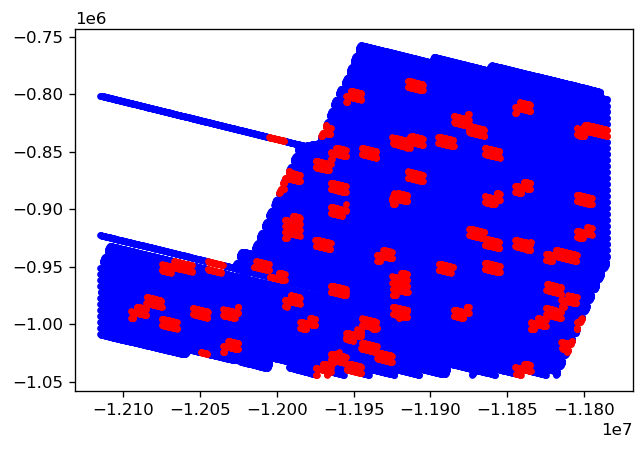

In [65]:
plt.plot(train[0][0], train[0][1], ".b")
plt.plot(test[0][0], test[0][1], ".r")

In [66]:
chain.fit(*train)

Chain(steps=[('trend', Trend(degree=1)),
             ('reduce',
              BlockReduce(reduction=<function median at 0x7f6c54385d90>,
                          spacing=5000)),
             ('spline', Spline())])

In [67]:
chain.score(*test)

0.47259971129455924

<a id="cv"></a>

## Cross-validation

https://www.fatiando.org/verde/v1.5.0/gallery/blockkfold.html#sphx-glr-gallery-blockkfold-py

In [75]:
cv = vd.BlockKFold(spacing=10e3, n_splits=10, shuffle=True, random_state=0)

In [76]:
%%time
scores = vd.cross_val_score(chain, coordinates, data.CORR_DEPTH, cv=cv)

CPU times: user 7min, sys: 7.15 s, total: 7min 8s
Wall time: 56.9 s


(array([1., 2., 5., 1., 1.]),
 array([0.3493389 , 0.4108603 , 0.47238169, 0.53390309, 0.59542448,
        0.65694588]),
 <a list of 5 Patch objects>)

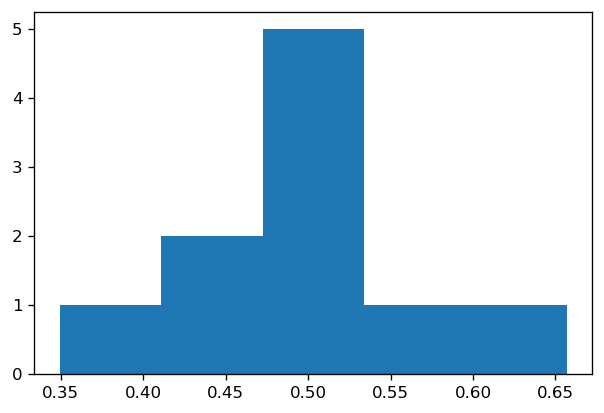

In [77]:
plt.hist(scores, bins="auto")

In [78]:
client = dask.distributed.Client()
client

/home/leo/miniconda3/envs/t20-thu-verde/lib/python3.7/site-packages/bokeh/resources.py:107: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/leo/miniconda3/envs/t20-thu-verde/lib/python3.7/site-packages/bokeh/_sri.json' mode='r' encoding='UTF-8'>
  _SRI_HASHES = json.load(open(join(ROOT_DIR, "_sri.json")))


Client Scheduler: tcp://127.0.0.1:34519 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.67 GB


In [79]:
%%time
scores = vd.cross_val_score(chain, coordinates, data.CORR_DEPTH, cv=cv, delayed=True)
scores = dask.compute(*scores)

CPU times: user 7.36 s, sys: 722 ms, total: 8.08 s
Wall time: 1min 6s


<a id="splinecv"></a>

## Hyper-parameter optimization

In [160]:
chain = vd.Chain([
    ("reduce", vd.BlockReduce(np.median, spacing=5000)),
    ("spline", vd.Spline(damping=1e-5, mindist=10e3)),
])

In [236]:
scores = vd.cross_val_score(chain, coordinates, data.CORR_DEPTH, cv=cv)

(array([1., 2., 0., 2.]),
 array([0.39022824, 0.42738345, 0.46453865, 0.50169386, 0.53884907]),
 <a list of 4 Patch objects>)

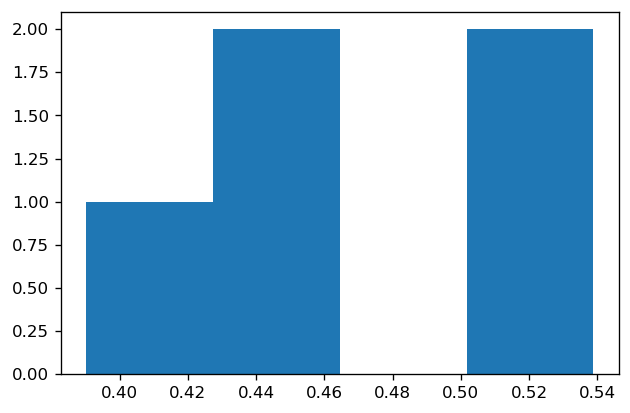

In [237]:
plt.hist(scores, bins="auto")

In [238]:
chain = vd.Chain([
    ("reduce", vd.BlockReduce(np.median, spacing=5000)),
    ("spline", vd.SplineCV(
        dampings=[None], mindists=[5e3, 10e3, 15e3], cv=cv, delayed=True)
    ),
])

In [239]:
chain.fit(*train)
chain.score(*test)

0.4917379462469056

In [240]:
chain.named_steps["spline"].damping_

1e-08

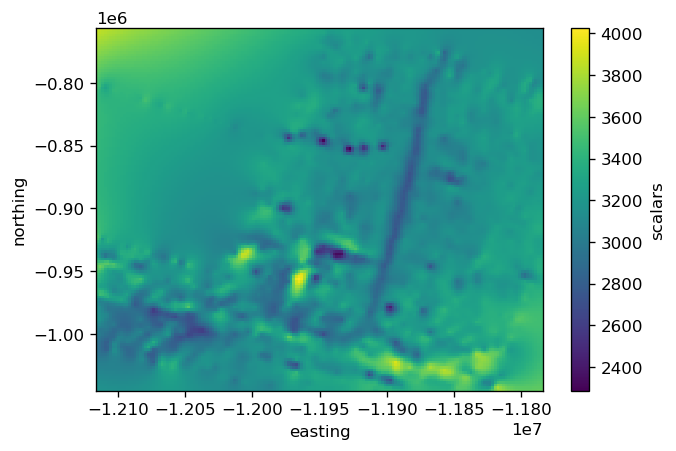

In [242]:
chain.grid(spacing=2000).scalars.plot()

<div style="background-color: #a3ff8e; border-radius: 3px; padding: 10px; text-align: center;">

# Wrap up and work on your own data
    
</div>

## License

All code and text in this notebook is free software: you can redistribute it and/or
modify it under the terms of the BSD 3-clause License.
A copy of this license is provided in [LICENSE](https://github.com/fatiando/transform2020/blob/master/LICENSE).